In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, preprocessing, ensemble, model_selection, feature_selection
from scipy.stats import boxcox
from scipy.spatial.distance import cdist
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

import pickle

In [2]:
"""read the data"""

data = pd.read_csv('ApartmentRentPrediction.csv')

print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             9000 non-null   int64  
 1   category       9000 non-null   object 
 2   title          9000 non-null   object 
 3   body           9000 non-null   object 
 4   amenities      5815 non-null   object 
 5   bathrooms      8970 non-null   float64
 6   bedrooms       8993 non-null   float64
 7   currency       9000 non-null   object 
 8   fee            9000 non-null   object 
 9   has_photo      9000 non-null   object 
 10  pets_allowed   5249 non-null   object 
 11  price          9000 non-null   int64  
 12  price_display  9000 non-null   object 
 13  price_type     9000 non-null   object 
 14  square_feet    9000 non-null   int64  
 15  address        6029 non-null   object 
 16  cityname       8934 non-null   object 
 17  state          8934 non-null   object 
 18  latitude

In [3]:
"""put the prediction column at the end"""

predicted_col = data['price_display']
data.drop(columns=['price_display', 'price'], inplace=True)
data['price_display'] = predicted_col

In [4]:
"""modify target format"""
data['price_display'] = data['price_display'].str.replace(r'[^0-9]', '', regex=True)
data['price_display'] = data['price_display'].astype(float)


print(data['price_display'].head(10))

0    1194.0
1    1370.0
2    1009.0
3     695.0
4    3695.0
5    1750.0
6    2470.0
7    1250.0
8    1789.0
9    1225.0
Name: price_display, dtype: float64


In [5]:
"""number of nulls"""
for column in data.columns:
  print(column, '\t',data[column].isna().sum())

id 	 0
category 	 0
title 	 0
body 	 0
amenities 	 3185
bathrooms 	 30
bedrooms 	 7
currency 	 0
fee 	 0
has_photo 	 0
pets_allowed 	 3751
price_type 	 0
square_feet 	 0
address 	 2971
cityname 	 66
state 	 66
latitude 	 7
longitude 	 7
source 	 0
time 	 0
price_display 	 0


In [6]:
class CounterEncoder:
  def transform(self, X):
    ret = X.copy()
    ret = ret.fillna(0).apply(lambda x: 0 if x == 0 else len(str(x).split(',')))
    return ret

In [7]:
"""replace each row in amenities with the **count** of the amenities"""
ce = CounterEncoder()
data['amenities'] = ce.transform(data['amenities'])
data.head(10)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_type,square_feet,address,cityname,state,latitude,longitude,source,time,price_display
0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...",6,2.5,2.0,USD,No,Thumbnail,...,Monthly,800,NaN,Cary,NC,35.7585,-78.7783,RentDigs.com,1568755960,1194.0
1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,9,1.0,1.0,USD,No,Thumbnail,...,Monthly,795,640 West Wilson St,Madison,WI,43.0724,-89.4003,RentLingo,1577015508,1370.0
2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...",7,1.0,1.0,USD,No,Thumbnail,...,Monthly,560,2777 SW Archer Road,Gainesville,FL,29.6533,-82.3656,RentLingo,1577358921,1009.0
3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",0,1.0,1.0,USD,No,Thumbnail,...,Monthly,600,534-542 Park Ave,Omaha,NE,41.2562,-96.0404,RentLingo,1577359849,695.0
4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",0,3.0,3.0,USD,No,Thumbnail,...,Monthly,1600,2216 S Palm Grove Avenue,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360159,3695.0
5,5664597879,housing/rent/apartment,Three BR 680 Bromley Dr.,"This unit is located at 680 Bromley Dr., Baton...",0,2.0,3.0,USD,No,Thumbnail,...,Monthly,2300,680 Bromley Drive,Baton Rouge,LA,30.4415,-91.1012,RentLingo,1577017123,1750.0
6,5509268702,housing/rent/apartment,Studio in Lynnwood,We believe that elevating where you live is al...,2,1.0,2.0,USD,No,Yes,...,Monthly,1079,NaN,Lynnwood,WA,47.8616,-122.2729,RentDigs.com,1568782110,2470.0
7,5664594606,housing/rent/apartment,Three BR 1712 Donald Dr,"This unit is located at 1712 Donald Dr, Shawne...",0,2.0,3.0,USD,No,Thumbnail,...,Monthly,1177,1712 Donald Drive,Shawnee,OK,35.3537,-96.8923,RentLingo,1577016836,1250.0
8,5668628991,housing/rent/apartment,One BR 2975 Blackburn St Apartment 678,This unit is located at 2975 Blackburn St Apar...,0,1.0,1.0,USD,No,Thumbnail,...,Monthly,678,2975 Blackburn St Apartment 678,Dallas,TX,32.8212,-96.7853,RentLingo,1577359585,1789.0
9,5668609854,housing/rent/apartment,Two BR 290 9th Ave Sw,"This unit is located at 290 ninth Ave Sw, Fore...",9,1.0,2.0,USD,No,Thumbnail,...,Monthly,995,290 9th Avenue SW,Forest Lake,MN,45.2764,-92.9901,RentLingo,1577358292,1225.0


In [8]:
"""remove noise"""
print(data['category'].value_counts())
data = data.drop(data[(data['category'] == 'housing/rent/short_term') | (data['category'] == 'housing/rent/home')].index)
print(data['category'].value_counts())


category
housing/rent/apartment     8997
housing/rent/short_term       2
housing/rent/home             1
Name: count, dtype: int64
category
housing/rent/apartment    8997
Name: count, dtype: int64


In [9]:
class MeansAndMods:
  def __init__(self):
    self.special = {}  #
  def fit(self, data):

    for col in data.columns:
      if data[col].dtype == 'object':  # Check if the column is categorical
        self.special[col] = data[col].mode()[0]
      elif data[col].dtype == 'float64':
        self.special[col] = data[col].mean()
      else:
        self.special[col] = data[col].mean().astype(int)

  def transform(self, col, value=None):
    if value is None:
      return col.fillna(self.special[col.name])
    else:
      return col.apply(lambda x: self.special[col.name] if x == value else x)

mam = MeansAndMods()
mam.fit(data)

C:\Users\DELL\AppData\Local\Temp\ipykernel_6856\2736100613.py:12: RuntimeWarning: invalid value encountered in cast
  self.special[col] = data[col].mean().astype(int)


In [10]:
data.dropna(subset=['longitude', 'latitude'], inplace=True)


In [11]:
# Note: The following line is Required as we want these 2 cols without any nulls

class KNN_PP:
  def __init__(self):
    self.knn =  KNeighborsClassifier(n_neighbors=1)

  def fit(self, X, Y):
    self.X_train = X[Y.notnull()]
    self.Y_train = Y.dropna()
    self.knn.fit(self.X_train, self.Y_train)

  def transform(self, X, Y):
    X_test = X[Y.isnull()]
    Y_pred = Y.copy()
    Y_pred[X_test.index] = self.knn.predict(X_test)
    return Y_pred

  def fit_transform(self, X, Y):
    self.fit(X, Y)
    return self.transform(X, Y)

city_KP = KNN_PP()
data['cityname'] = city_KP.fit_transform(data.loc[:, ['latitude', 'longitude']], data['cityname'])
state_KP = KNN_PP()
data['state'] = state_KP.fit_transform(data.loc[:, ['latitude', 'longitude']], data['state'])


In [12]:
data['bathrooms'] = mam.transform(data['bathrooms'])
data['bedrooms']  = mam.transform(data['bedrooms'])

data['bathrooms'] = data['bathrooms'].astype(int)
data['bedrooms'] = data['bedrooms'].astype(int)

In [13]:
class OHE:
  def __init__(self, removeCol):
    self.removeCol = removeCol
  def fit(self, data, suff = 'allowed'):
    self.addCols = set()
    for val in data[self.removeCol].value_counts().index:
      for string in str(val).split(','):
        self.addCols.add(string.lower() + '_' + suff)

  def transform(self, data):
    data[self.removeCol].fillna('', inplace=True)
    for col in self.addCols:
      data.insert(data.columns.get_loc(self.removeCol), col, np.zeros(data.shape[0], dtype=int))
      data.loc[data[self.removeCol].str.contains(col[:col.find('_')], case=False), col] = 1
    data.drop(columns=self.removeCol, inplace=True)

  def fit_transform(self, data, suff = 'allowed'):
    self.fit(data, suff)
    self.transform(data)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8990 entries, 0 to 8999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             8990 non-null   int64  
 1   category       8990 non-null   object 
 2   title          8990 non-null   object 
 3   body           8990 non-null   object 
 4   amenities      8990 non-null   int64  
 5   bathrooms      8990 non-null   int32  
 6   bedrooms       8990 non-null   int32  
 7   currency       8990 non-null   object 
 8   fee            8990 non-null   object 
 9   has_photo      8990 non-null   object 
 10  pets_allowed   5245 non-null   object 
 11  price_type     8990 non-null   object 
 12  square_feet    8990 non-null   int64  
 13  address        6028 non-null   object 
 14  cityname       8990 non-null   object 
 15  state          8990 non-null   object 
 16  latitude       8990 non-null   float64
 17  longitude      8990 non-null   float64
 18  source       

In [14]:
print(data['pets_allowed'].value_counts())

pets_ohe = OHE(removeCol='pets_allowed')
pets_ohe.fit_transform(data)

print(data['cats_allowed'].value_counts(), data['dogs_allowed'].value_counts())


pets_allowed
Cats,Dogs    4700
Cats          431
Dogs          114
Name: count, dtype: int64
cats_allowed
1    5131
0    3859
Name: count, dtype: int64 dogs_allowed
1    4814
0    4176
Name: count, dtype: int64


In [15]:
data['address'].fillna('Unknown', inplace=True)
mam.fit(data)


C:\Users\DELL\AppData\Local\Temp\ipykernel_6856\2736100613.py:12: RuntimeWarning: invalid value encountered in cast
  self.special[col] = data[col].mean().astype(int)


In [16]:
for col in data.columns:
    data[col] = mam.transform(data[col])



In [17]:
"""number of nulls"""
for column in data.columns:
  print(column, '\t',data[column].isna().sum())

id 	 0
category 	 0
title 	 0
body 	 0
amenities 	 0
bathrooms 	 0
bedrooms 	 0
currency 	 0
fee 	 0
has_photo 	 0
dogs_allowed 	 0
cats_allowed 	 0
price_type 	 0
square_feet 	 0
address 	 0
cityname 	 0
state 	 0
latitude 	 0
longitude 	 0
source 	 0
time 	 0
price_display 	 0


In [18]:
photo_ohe = OHE('has_photo')
photo_ohe.fit_transform(data, 'photo')
data.drop(columns=['no_photo'], inplace=True)

In [19]:
def count_outliers(df):
    for column_name in df.columns:
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
        print(f"Number of outliers in '{column_name}': {outliers.shape[0]}")


In [20]:
outliercolums = ['bathrooms', 'bedrooms', 'square_feet','price_display']
print(count_outliers(data[outliercolums]))
# pd.set_option('display.max_rows', None)
print(data['bedrooms'].value_counts())

Number of outliers in 'bathrooms': 63
Number of outliers in 'bedrooms': 465
Number of outliers in 'square_feet': 573
Number of outliers in 'price_display': 554
None
bedrooms
1    4170
2    3031
3    1153
4     368
0     171
5      79
6      12
7       3
8       2
9       1
Name: count, dtype: int64


<Axes: ylabel='square_feet'>

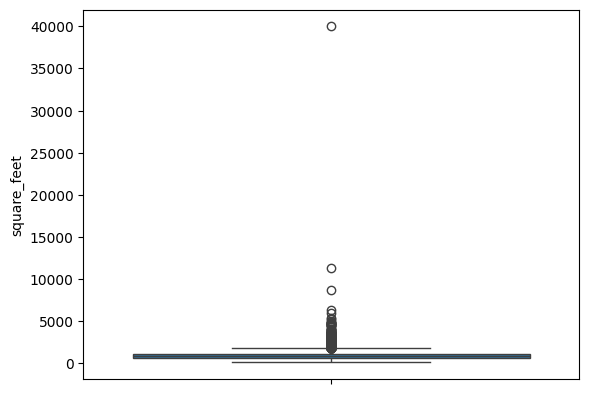

In [21]:
sns.boxplot(data['square_feet'])

<Axes: ylabel='price_display'>

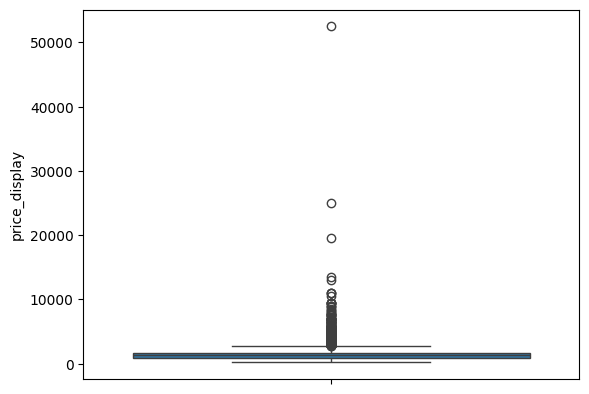

In [22]:
sns.boxplot(data['price_display'])

<Axes: ylabel='bedrooms'>

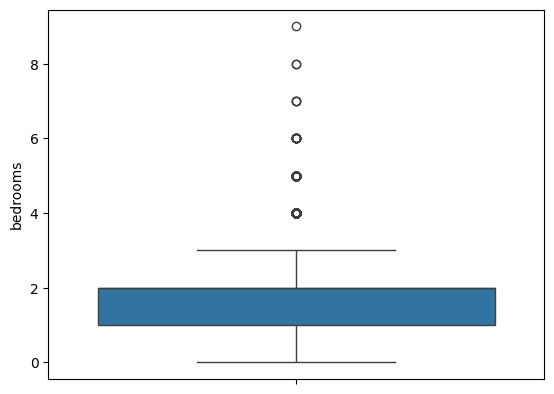

In [23]:
sns.boxplot(data['bedrooms'])

<Axes: ylabel='bathrooms'>

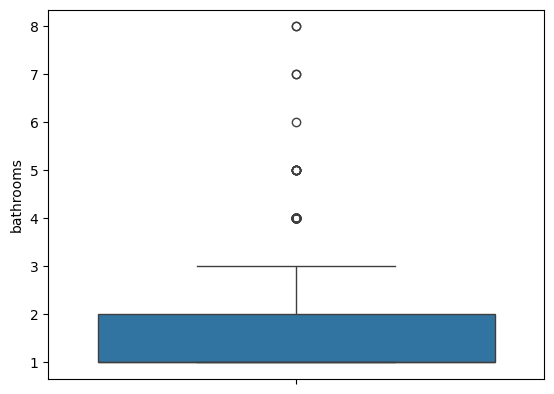

In [24]:
sns.boxplot(data['bathrooms'])

In [25]:
def replace_outliers(df, columns):
    for column_name in columns:
        # Calculate quartiles
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        # Calculate IQR
        IQR = Q3 - Q1
        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Replace outliers below the lower bound with Q1 - 1.5 * IQR
        df.loc[df[column_name] < lower_bound, column_name] = lower_bound
        # Replace outliers above the upper bound with Q3 + 1.5 * IQR
        df.loc[df[column_name] > upper_bound, column_name] = upper_bound
    return df

In [26]:
data = replace_outliers(data, outliercolums)
print(count_outliers(data[outliercolums]))
#print(train_data['square_feet'].max())


Number of outliers in 'bathrooms': 0
Number of outliers in 'bedrooms': 0
Number of outliers in 'square_feet': 0
Number of outliers in 'price_display': 0
None


C:\Users\DELL\AppData\Local\Temp\ipykernel_6856\3512025756.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.5' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[df[column_name] < lower_bound, column_name] = lower_bound
C:\Users\DELL\AppData\Local\Temp\ipykernel_6856\3512025756.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.5' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[df[column_name] < lower_bound, column_name] = lower_bound


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8990 entries, 0 to 8999
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8990 non-null   int64  
 1   category         8990 non-null   object 
 2   title            8990 non-null   object 
 3   body             8990 non-null   object 
 4   amenities        8990 non-null   int64  
 5   bathrooms        8990 non-null   float64
 6   bedrooms         8990 non-null   float64
 7   currency         8990 non-null   object 
 8   fee              8990 non-null   object 
 9   yes_photo        8990 non-null   int32  
 10  thumbnail_photo  8990 non-null   int32  
 11  dogs_allowed     8990 non-null   int32  
 12  cats_allowed     8990 non-null   int32  
 13  price_type       8990 non-null   object 
 14  square_feet      8990 non-null   int64  
 15  address          8990 non-null   object 
 16  cityname         8990 non-null   object 
 17  state            89

In [28]:
train_data = data.drop(data[(data['price_type'] == 'Weekly') | (data['price_type'] == 'Monthly|Weekly')].index)
mam.fit(train_data)

C:\Users\DELL\AppData\Local\Temp\ipykernel_6856\2736100613.py:12: RuntimeWarning: invalid value encountered in cast
  self.special[col] = data[col].mean().astype(int)


In [29]:
cols=('category','title','body','cityname', 'state', 'source', 'address','fee','currency','price_type')

lbls = []
for c in cols:
    lbl = LabelEncoder()
    data[c] = lbl.fit_transform(list(data[c].values))
    lbls.append(lbl)


In [30]:
# from sklearn.preprocessing import MinMaxScaler
# column_names = train_data.columns

# scaler = MinMaxScaler(feature_range=(0, 1))

# train_data_scaled = scaler.fit_transform(train_data)
# train_data_scaled_df = pd.DataFrame(train_data_scaled, columns=column_names)

# train_data = train_data_scaled_df

In [31]:
# test_data_scaled = scaler.transform(test_data)
# test_data_scaled_df = pd.DataFrame(test_data_scaled, columns=column_names)

# test_data = test_data_scaled_df


In [32]:
from sklearn.preprocessing import MinMaxScaler

price_t = data['price_display']
data.drop(columns=['price_display'], inplace = True)

column_names = data.columns

scaler = MinMaxScaler(feature_range=(0, 1))
print(train_data.info())
train_data_scaled = scaler.fit_transform(data)

train_data_scaled_df = pd.DataFrame(train_data_scaled, columns=column_names)

data = train_data_scaled_df
data['price_display'] = price_t.values

<class 'pandas.core.frame.DataFrame'>
Index: 8988 entries, 0 to 8999
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8988 non-null   int64  
 1   category         8988 non-null   object 
 2   title            8988 non-null   object 
 3   body             8988 non-null   object 
 4   amenities        8988 non-null   int64  
 5   bathrooms        8988 non-null   float64
 6   bedrooms         8988 non-null   float64
 7   currency         8988 non-null   object 
 8   fee              8988 non-null   object 
 9   yes_photo        8988 non-null   int32  
 10  thumbnail_photo  8988 non-null   int32  
 11  dogs_allowed     8988 non-null   int32  
 12  cats_allowed     8988 non-null   int32  
 13  price_type       8988 non-null   object 
 14  square_feet      8988 non-null   int64  
 15  address          8988 non-null   object 
 16  cityname         8988 non-null   object 
 17  state            89

In [33]:
data = data.drop('category', axis=1)
data = data.drop('currency', axis=1)
data = data.drop('fee', axis=1)
data = data.drop('price_type', axis=1)

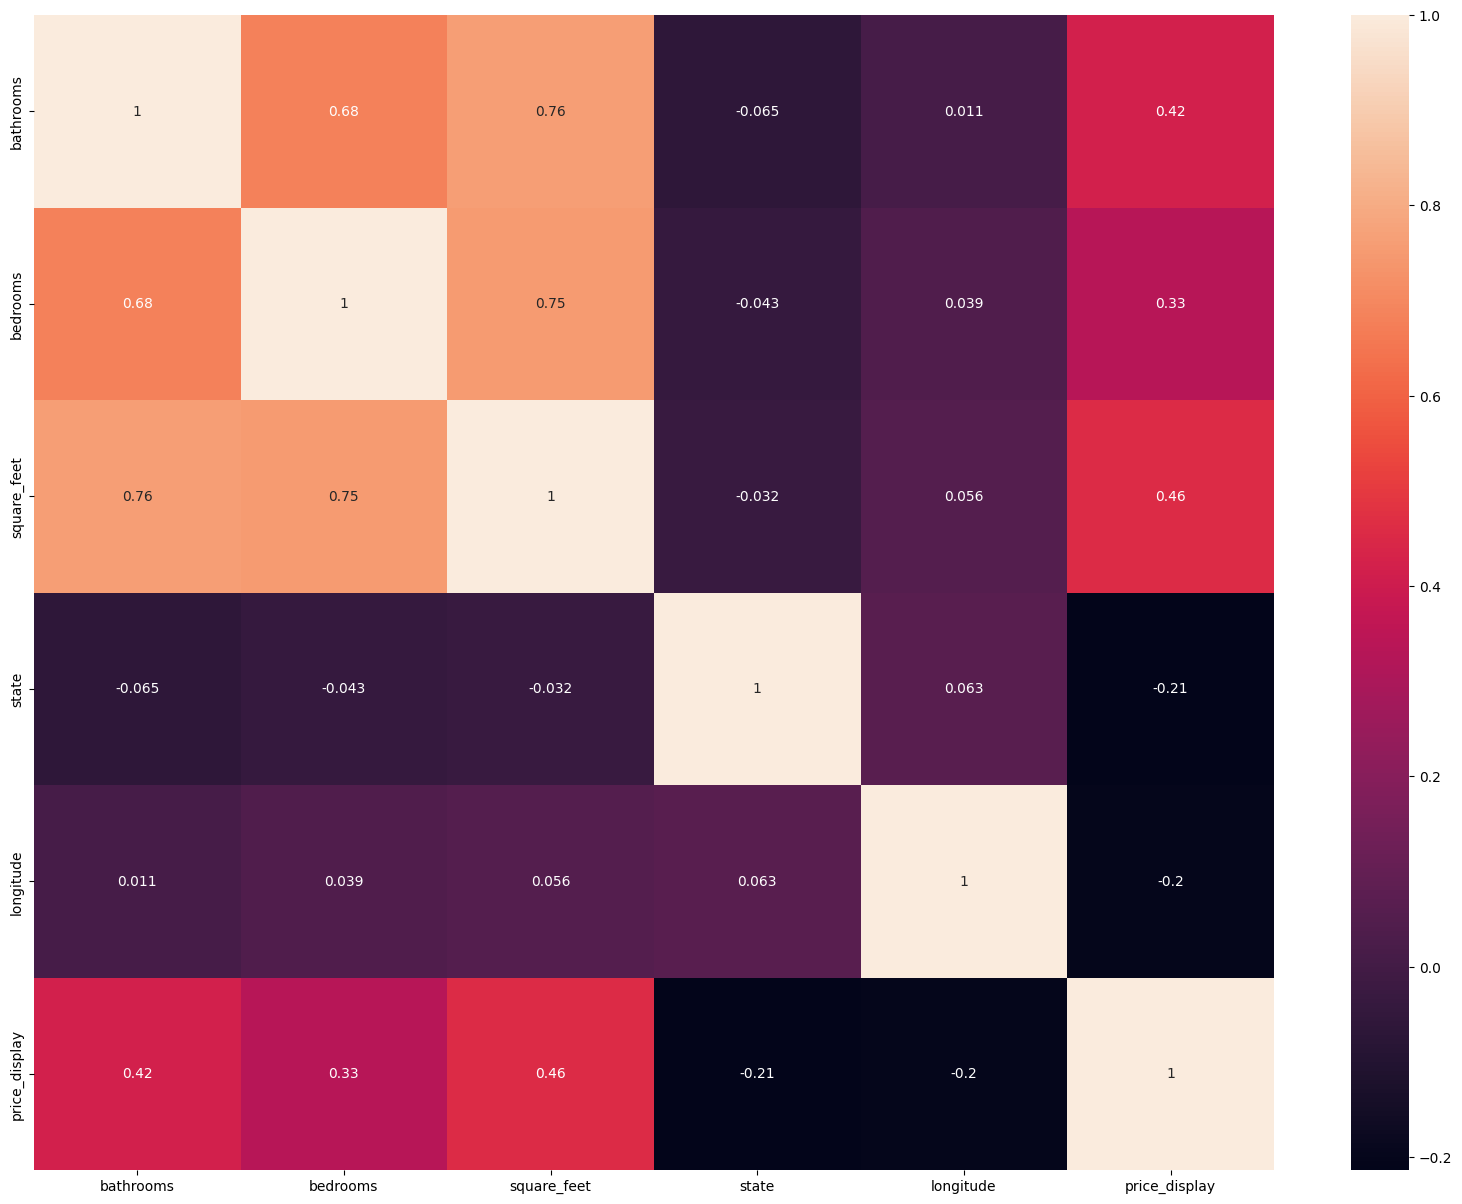

Index(['bathrooms', 'bedrooms', 'square_feet', 'state', 'longitude',
       'price_display'],
      dtype='object')
Index(['bathrooms', 'bedrooms', 'square_feet', 'state', 'longitude'], dtype='object')
X_train shape: (7192, 5)
X_test shape: (1798, 5)
Y_train shape: (7192,)
Y_test shape: (1798,)


In [34]:

c = data.corr()
top_features = c.index[abs(c['price_display'])>=0.15]
plt.subplots(figsize=(20, 15))
top_corr = data[top_features].corr()
sns.heatmap(top_corr, annot=True)
plt.show()
print(top_features)
top_features = top_features[:-1]
print(top_features)

X = data[top_features]
Y = data['price_display']

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Check the shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


In [35]:
poly_degree = 4 # Changed to degree 4
poly = PolynomialFeatures(degree=poly_degree)

X_train_selected = X_train
X_test_selected = X_test

X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

In [36]:
model = LinearRegression()
model.fit(X_train_poly,Y_train)

# Step 3: Make predictions
train_predictions = model.predict(X_train_poly)
test_predictions = model.predict(X_test_poly)
print(train_predictions)


[1048.16586178 2570.23020619  861.79964075 ... 1380.44160976 1881.79146259
 2356.99110162]


In [37]:
train_r2 = r2_score(Y_train, train_predictions)
train_mse = metrics.mean_squared_error(Y_train, train_predictions)

test_r2 = r2_score(Y_test, test_predictions)
test_mse = metrics.mean_squared_error(Y_test, test_predictions)

print("Training R^2:", train_r2)
print("Training MSE:", train_mse)
print("Testing R^2:", test_r2)
print("Testing MSE:", test_mse)

Training R^2: 0.5951152725107212
Training MSE: 148285.65945602092
Testing R^2: 0.5448907977886867
Testing MSE: 163923.57240973535


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# Select features from training and testing data
X_train_selected = X_train
X_test_selected = X_test

# Step 2: Train the model
model = LinearRegression()
model.fit(X_train_selected, Y_train)

# Step 3: Make predictions
y_train_predicted = model.predict(X_train_selected)
y_pred = model.predict(X_test_selected)

# Step 4: Evaluation
train_mse = metrics.mean_squared_error(Y_train, y_train_predicted)
test_mse = metrics.mean_squared_error(Y_test, y_pred)
r2train = model.score(X_train_selected, Y_train)
r2test = model.score(X_test_selected, Y_test)

print('Training Mean Square Error:', train_mse)
print('Testing Mean Square Error:', test_mse)
print("r2train score:", r2train)
print("r2test score:", r2test)


Training Mean Square Error: 251829.97965365704
Testing Mean Square Error: 260766.7481547604
r2train score: 0.31239397619604725
r2test score: 0.2760202515638728


In [39]:
from sklearn.ensemble import RandomForestRegressor

# Step 2: Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, Y_train)

# Step 3: Make predictions
rf_y_train_predicted = rf_model.predict(X_train_selected)
rf_y_pred = rf_model.predict(X_test_selected)

# Step 4: Evaluation
rf_train_mse = metrics.mean_squared_error(Y_train, rf_y_train_predicted)
rf_test_mse = metrics.mean_squared_error(Y_test, rf_y_pred)
rf_r2train = r2_score(rf_y_train_predicted, Y_train)

rf_r2test = r2_score(rf_y_pred, Y_test)

print('Random Forest Training Mean Square Error:', rf_train_mse)
print('Random Forest Testing Mean Square Error:', rf_test_mse)
print("Random Forest r2train score:", rf_r2train)
print("Random Forest r2test score:", rf_r2test)


Random Forest Training Mean Square Error: 15590.384221088349
Random Forest Testing Mean Square Error: 100779.55796785421
Random Forest r2train score: 0.9505557741175253
Random Forest r2test score: 0.6499543899227569


In [40]:
with open('testScript.pkl', 'wb') as f:
    pickle.dump(rf_model,f)
    pickle.dump(ce, f)
    pickle.dump(mam, f)
    pickle.dump(city_KP, f)
    pickle.dump(state_KP, f)
    pickle.dump(photo_ohe, f)
    pickle.dump(pets_ohe, f)
    pickle.dump(scaler, f)
    for lbl in lbls:
      pickle.dump(lbl, f)

In [41]:
loaded_lbls = []
with open('testScript.pkl', 'rb') as f:
    loaded_rf = pickle.load(f)
    loaded_ce = pickle.load(f)
    loaded_mam = pickle.load(f)
    loaded_city_KP = pickle.load(f)
    loaded_state_KP = pickle.load(f)
    loaded_photo_ohe = pickle.load(f)
    loaded_pets_ohe = pickle.load(f)
    loaded_scaler = pickle.load(f)
    for lbl in lbls:
      loaded_lbls.append(pickle.load(f))


In [42]:
data = pd.read_csv('ApartmentRentPrediction.csv')
data['price_display'] = data['price_display'].str.replace(r'[^0-9]', '', regex=True)
data['price_display'] = data['price_display'].astype(float)

data.drop(columns=['price'], inplace=True)


data['amenities'] = loaded_ce.transform(data['amenities'])


data['latitude'] = loaded_mam.transform(data['latitude'])
data['longitude'] = loaded_mam.transform(data['longitude'])

data['cityname'] = loaded_city_KP.transform(data.loc[:, ['latitude', 'longitude']], data['cityname'])
data['state'] = loaded_state_KP.transform(data.loc[:, ['latitude', 'longitude']], data['state'])

loaded_pets_ohe.transform(data)

loaded_photo_ohe.transform(data)
data.drop(columns=['no_photo'],inplace = True)
for col in data.columns:
  data[col] = loaded_mam.transform(data[col])


# data['bathrooms'] = loaded_mam.transform(data['bathrooms'])
# data['bedrooms']  = loaded_mam.transform(data['bedrooms'])
# data['address'] = loaded_mam.transform(data['address'])

data['bathrooms'] = data['bathrooms'].astype(int)
data['bedrooms'] = data['bedrooms'].astype(int)


In [43]:
cols=('category','title','body','cityname', 'state', 'source', 'address','fee','currency','price_type')
for c in cols:
  lbl = loaded_lbls.pop(0)
  for idx, val in data[c].items():
    if val not in lbl.classes_:
      data.at[idx,c]= loaded_mam.special[c]
  data[c] = lbl.transform(data[c])

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9000 non-null   int64  
 1   category         9000 non-null   int32  
 2   title            9000 non-null   int32  
 3   body             9000 non-null   int32  
 4   amenities        9000 non-null   int64  
 5   bathrooms        9000 non-null   int32  
 6   bedrooms         9000 non-null   int32  
 7   currency         9000 non-null   int32  
 8   fee              9000 non-null   int32  
 9   yes_photo        9000 non-null   int32  
 10  thumbnail_photo  9000 non-null   int32  
 11  dogs_allowed     9000 non-null   int32  
 12  cats_allowed     9000 non-null   int32  
 13  price_display    9000 non-null   float64
 14  price_type       9000 non-null   int32  
 15  square_feet      9000 non-null   int64  
 16  address          9000 non-null   int32  
 17  cityname      

In [44]:
price_t = data['price_display']
data.drop(columns=['price_display'], inplace = True)

column_names = data.columns


data_scaled = loaded_scaler.transform(data)

data_scaled_df = pd.DataFrame(data_scaled, columns=column_names)

data = data_scaled_df
data['price_display'] = price_t.values

In [45]:
y = data['price_display']
x_rf = data[['bathrooms','bedrooms','square_feet','state','longitude']]


y_pred = loaded_rf.predict(x_rf)


data_mse = metrics.mean_squared_error(y, y_pred)
r2 = r2_score(y_pred, y)

print('Random Forest data Mean Square Error:', data_mse)
print("Random Forest r2test score:", r2)

Random Forest data Mean Square Error: 640899.7600166629
Random Forest r2test score: -1.067701354042892
